In [1]:
import pandas as pd
import numpy as np
import shutil
import subprocess
import time
import pandas as pd
import sqlite3
import numpy as np
calibration_start_time = time.time()


# MinDist = 1 #1~3
# MaxAcc = 3 #2.5~3
# NormalDec = 4 #4~5.3
# MaxDec = 6 #5~9.3
# MinHeadway = 0 #0.25~1.25
# SensitivityFactor = 1 #0~1
initial_solution = np.array([1,3,4,6,0,1])

def newParameter(initial_solution):
    Parameter = np.genfromtxt('DrivingBehaviorParameter.csv', delimiter=',')
    Parameter = initial_solution
    np.savetxt('DrivingBehaviorParameter.csv', Parameter, delimiter=',', fmt='%s')

   
    # cmd1 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\Aimsun Next.exe" --project "D:\\RealTwin\\Real-Twin Workflow Paper\\aimsun simulation_0506actuatedsignal\\chatt.ang" --command execute --target 1269'
    cmd1 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\aconsole.exe" -script "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\DrivingBehavior.py" "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\chatt.ang"'
    process = subprocess.Popen(cmd1, shell=True)
    # process = subprocess.Popen(cmd1, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    process.wait()

def runAimsun():
    cmd2 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\aconsole.exe" --project "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\chatt.ang" --command execute --target 955'
    process = subprocess.Popen(cmd2, shell=True)
    process.wait()

def resultAnalysis():
    dataname = "Resources\Outputs\chatt.sqlite"
    con = sqlite3.connect(dataname)
    section0 = pd.read_sql_query("SELECT * from MISECT", con)
    section = section0[(section0['sid'] == 1) & (section0['ent'] == 1)]
    con.close()
    # section.to_excel('section.xlsx', index=False)
    compare = pd.read_excel('compare.xlsx')
    compare = compare.merge(section[['oid', 'count']], left_on='entrance', right_on='oid', how='left')
    compare.drop(columns='oid', inplace=True)
    compare['GEH'] = np.sqrt(2 * ((compare['count'] - compare['realcount']) ** 2) / (compare['count'] + compare['realcount']))
    meanGEH = compare['GEH'].mean()
    GEHPercent = (compare['GEH'] < 5).mean()
    return meanGEH,GEHPercent

def resultFitness(path1_id,path2_id,path1_tt,path2_tt):
    dataname = "Resources\Outputs\chatt.sqlite"
    con = sqlite3.connect(dataname)
    subpath0 = pd.read_sql_query("SELECT * from MISUBPATH", con)
    tt1 = subpath0[(subpath0['oid'] == path1_id) & (subpath0['sid'] == 0) & (subpath0['ent'] == 0)]['ttime'].iloc[0]
    tt2 = subpath0[(subpath0['oid'] == path2_id) & (subpath0['sid'] == 0) & (subpath0['ent'] == 0)]['ttime'].iloc[0]
    con.close()
    MAE = (abs(path1_tt-tt1)+abs(path2_tt-tt2))/2
    
    return MAE

In [ ]:
# def normalize(value, min_val, max_val):
#     return (value - min_val) / (max_val - min_val)

# def denormalize(normalized_value, min_val, max_val):
#     return normalized_value * (max_val - min_val) + min_val



# def objective_function(x,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges):
#     # Denormalize the parameters
#     denormalized_x = np.zeros_like(x)
#     for i in range(len(x)):
#         min_val, max_val = parameter_ranges[i]
#         denormalized_x[i] = denormalize(x[i], min_val, max_val)
#     newParameter(denormalized_x)
#     runAimsun()
#     value = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
#     return value


# parameter_ranges = [
#     (1, 3),   # Range for min dist/spacing
#     (2.5, 3),   # Range for max acceleration
#     (4, 5.3), # Range for normal deceleration
#     (5, 9.3),    # Range for max deceleration
#     (0.25, 1.25), # Range for min headway
#     (0, 1)   # Range for sensitivity factor
# ]

# initial_solution = np.array([1,3,4,6,0,1])
# x = np.zeros_like(initial_solution)
# for i in range(6):
#     min_val, max_val = parameter_ranges[i]
#     x[i] = normalize(initial_solution[i], min_val, max_val)

# path1_id = 1286 #EB
# path2_id = 1287 #WB
# path1_tt = 240
# path2_tt = 180

# value = objective_function(x,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)

In [ ]:
# GA Parameters
MinDist = 1 #1~3
MaxAcc = 2.5 #2.5~3
NormalDec = 4 #4~5.3
MaxDec = 5 #5~9.3
MinHeadway = 0.25 #0.25~1.25
SensitivityFactor = 1 #0~1
#HeadwayAggressiveness=1 #-1~1
#AccAggressiveness=1 #-1~1

path1_id = 1286 #EB
path2_id = 1287 #WB
path1_tt = 240
path2_tt = 180

parameter_ranges = [
    (1, 3),   # Range for min dist/spacing
    (2.5, 3),   # Range for max acceleration
    (4, 5.3), # Range for normal deceleration
    (5, 9.3),    # Range for max deceleration
    (0.25, 1.25), # Range for min headway
    (0, 1)   # Range for sensitivity factor
]


population_size = 50  # must be even
num_generations = 30
crossover_rate = 0.75
mutation_rate = 0.1
elitism_size = 1  # Number of elite individuals to carry over
best_fitness_value = float('inf')
max_no_improvement = 5  # Stop if no improvement in 5 iterations

minGEHset = []




def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

def denormalize(normalized_value, min_val, max_val):
    return normalized_value * (max_val - min_val) + min_val



def objective_function(x,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges):
    # Denormalize the parameters
    denormalized_x = np.zeros_like(x)
    for i in range(len(x)):
        min_val, max_val = parameter_ranges[i]
        denormalized_x[i] = denormalize(x[i], min_val, max_val)
    newParameter(denormalized_x)
    runAimsun()
    value = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
    return value

# Initialize population

num_variables = len(parameter_ranges)
population_notnormalized = np.zeros((population_size, num_variables))

for i in range(num_variables):
    min_val, max_val = parameter_ranges[i]
    population_notnormalized[:, i] = np.random.uniform(min_val, max_val, population_size)


population = np.zeros_like(population_notnormalized)

for i in range(num_variables):
    min_val, max_val = parameter_ranges[i]
    population[:, i] = normalize(population_notnormalized[:, i], min_val, max_val)


# Evolution loop
iterations_without_improvement = 0
calibration_start_time = time.time()
for generation in range(num_generations):
    print('Calibration iteration {}:'.format(generation))
    # Evaluate fitness
    fitness = np.zeros(population_size)
    for i in range(population_size):
        fitness[i] = objective_function(population[i],path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)
    # print(population)
    # print(fitness)

    # Check for improvement
    current_best_fitness = np.min(fitness)
    minGEHset.append(current_best_fitness)
    print('    minimum mean GEH in this iteration is {}.'.format(current_best_fitness))

    # if current_best_fitness < best_fitness_value:
    #     best_fitness_value = current_best_fitness
    #     iterations_without_improvement = 0
    # else:
    #     iterations_without_improvement += 1
    # # Check if stopping criteria met
    # if iterations_without_improvement >= max_no_improvement:
    #     print("No improvement in the last {} iterations. Stopping early.".format(max_no_improvement))
    #     break

    # Elitism
    elite_indices = np.argsort(fitness)[:elitism_size]
    elite_individuals = population[elite_indices]
    
    # Selection (tournament)
    max_fitness = np.max(fitness)
    inverted_fitness = max_fitness + 1 - fitness
    selected_indices = np.random.choice(range(population_size), size=population_size - elitism_size, replace=True, p=inverted_fitness / np.sum(inverted_fitness))
    selected_population = population[selected_indices]
    
    # Crossover
    offspring = []
    num_offspring = population_size - elitism_size
    for i in range(0, num_offspring, 2):
        if np.random.rand() < crossover_rate and i + 1 < num_offspring:
            crossover_point = np.random.randint(1, num_variables)
            offspring1 = np.concatenate((selected_population[i][:crossover_point], selected_population[i + 1][crossover_point:]))
            offspring2 = np.concatenate((selected_population[i + 1][:crossover_point], selected_population[i][crossover_point:]))
            offspring.append(offspring1)
            offspring.append(offspring2)
        else:
            offspring.append(selected_population[i])
            if i + 1 < num_offspring:
                offspring.append(selected_population[i + 1])
    offspring = np.array(offspring)

    
    # Mutation
    mutation_indices = np.random.rand(population_size - elitism_size, num_variables) < mutation_rate
    offspring[mutation_indices] = np.random.rand(np.sum(mutation_indices))
    
    # Update population
    if generation < num_generations-1:  # avoid change population after final iteration
        population = np.vstack((elite_individuals, offspring))
    print("Current calibration time is {} sec.".format(time.time() - calibration_start_time))
    # print(population)

# Find the best solution
best_fitness_index = np.argmin(fitness)
best_solution = population[best_fitness_index].copy()


denormalized_best_solution = np.zeros_like(best_solution)
for i in range(len(best_solution)):
    min_val, max_val = parameter_ranges[i]
    denormalized_best_solution[i] = denormalize(best_solution[i], min_val, max_val)
newParameter(denormalized_best_solution)
runAimsun()
best_MAE = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
final_GEH,final_GEHpercent = resultAnalysis()
print("Best solution:", denormalized_best_solution)
print("Best MAE:", best_MAE) 
print("Final GEH:", final_GEH) 
print("In final results, {} percent GEH is lower than 5.".format(int(final_GEHpercent*10000)/100))

# if flag:
#     print("All traffic volume requirements are met.")
# else:
#     print("Not all traffic volume requirements are met.")
np.savetxt('GA_parameter_best.txt', denormalized_best_solution , fmt='%f')

# intial MAE = 31.72

Calibration iteration 0:
    minimum mean GEH in this iteration is 22.63901208010948.
Current calibration time is 471.59222292900085 sec.
Calibration iteration 1:
    minimum mean GEH in this iteration is 22.46873015201399.
Current calibration time is 969.8094236850739 sec.
Calibration iteration 2:
    minimum mean GEH in this iteration is 19.246997097422465.
Current calibration time is 1442.8000011444092 sec.
Calibration iteration 3:
    minimum mean GEH in this iteration is 19.246997097422465.
Current calibration time is 1920.9925305843353 sec.
Calibration iteration 4:
    minimum mean GEH in this iteration is 19.246997097422465.
Current calibration time is 2409.090663433075 sec.
Calibration iteration 5:
    minimum mean GEH in this iteration is 19.246997097422465.
Current calibration time is 2896.687488079071 sec.
Calibration iteration 6:
    minimum mean GEH in this iteration is 19.10985854171203.
Current calibration time is 3378.895627975464 sec.
Calibration iteration 7:
    minim

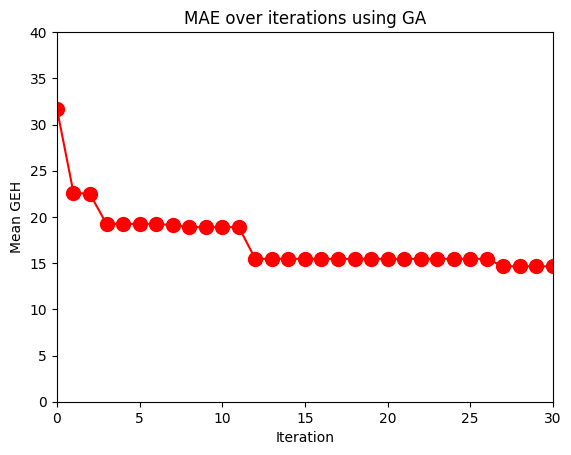

In [7]:
minGEHset
import matplotlib.pyplot as plt

plt.plot(range(0,num_generations+1), [31.72] + minGEHset, 'o-', color='red', markersize=10)

plt.xlabel('Iteration')
plt.ylabel('Mean GEH')
plt.title('MAE over iterations using GA')
# plt.legend()
# plt.xticks(ticks=range(0,21))  
plt.xticks(range(0,31,5))
plt.xlim(0, 30)
plt.ylim(0, 40)
plt.show()

In [5]:
minGEHset

[22.63901208010948,
 22.46873015201399,
 19.246997097422465,
 19.246997097422465,
 19.246997097422465,
 19.246997097422465,
 19.10985854171203,
 18.89764606598372,
 18.89764606598372,
 18.89764606598372,
 18.89764606598372,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 15.460403026665006,
 14.653106531692515,
 14.653106531692515,
 14.653106531692515,
 14.653106531692515]

In [8]:
best_solution

array([0.28357758, 0.00480559, 0.29742875, 0.65472317, 0.01153466,
       0.28300184])

In [ ]:
import numpy as np
path1_id = 1286 #EB
path2_id = 1287 #WB
path1_tt = 240
path2_tt = 180
parameter_ranges = [
    (1, 3),   # Range for min dist/spacing
    (2.5, 3),   # Range for max acceleration
    (4, 5.3), # Range for normal deceleration
    (5, 9.3),    # Range for max deceleration
    (0.25, 1.25), # Range for min headway
    (0, 1)   # Range for sensitivity factor
]


def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

def denormalize(normalized_value, min_val, max_val):
    return normalized_value * (max_val - min_val) + min_val


def objective_function(x,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges):
    # Denormalize the parameters
    denormalized_x = np.zeros_like(x)
    for i in range(len(x)):
        min_val, max_val = parameter_ranges[i]
        denormalized_x[i] = denormalize(x[i], min_val, max_val)
    newParameter(denormalized_x)
    runAimsun()
    value = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
    return value

best_solution = np.array([0.28357758, 0.00480559, 0.29742875, 0.65472317, 0.01153466,
       0.28300184])

fit = objective_function(best_solution,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)